In [1]:
%matplotlib inline

import numpy as np;
import time;
import numba as jit;
from copy import deepcopy;
import matplotlib.pyplot as plt
from IPython import display

(2, 3618)


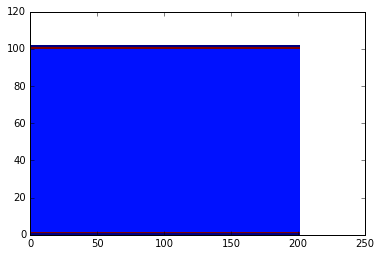

In [2]:
# GRID

#           4    3    2
#
#           5    0    1
#
#           6    7    8

# Define variables used
directions               = 9;
relaxation_constant      = 0.8;
grid_step_x              = 5E-3;
grid_step_y              = 1E-2;
speed_of_sound           = 1;
time_step                = 1 / speed_of_sound;
directional_weights      = np.array([16,4,1,4,1,4,1,4,1]) / 36;
unit_x_velocities        = np.array([0, 1, 1, 0, -1, -1, -1, 0, 1]);
unit_y_velocities        = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1]);
ei                       = np.stack((unit_x_velocities, unit_y_velocities));
oppositeDirection        = np.array([0, 5, 6, 7, 8, 1, 2, 3, 4]);
density                  = 1E0;
mass                     = 1E0;
particles_per_grid_point = 1E1;
average_density          = particles_per_grid_point;

# Create the grid. We use a triangular grid
x          = np.linspace(0, 1, 1 / grid_step_x + 1);
y          = np.linspace(-grid_step_y/2, 1 + grid_step_y/2, 1/grid_step_y + 2);
[X, Y]     = np.meshgrid(x,y);                     # This is a rectangular grid

# Create the velocity grid.
u           = np.ones(np.shape(x)) * 0.0;                 # Initial x velocity is uniformly 1
v           = np.zeros(np.shape(y));
[U, V]      = np.meshgrid(u,v);
U = np.dstack((U,V));

# Place walls etc
Active = np.ones(X.shape);
Active[[0,-1],:] = 0; # Top and bottom boundary

# Calculate the boundary elements
Boundary = np.zeros(X.shape);
for i in range(1,9):
    Boundary = Boundary + np.roll(np.roll(Active, ei[0,i], axis=1), ei[1,i], axis=0);

# All locations which are smaller than 8 and active are a boundary
Boundary = ((8 - Boundary) * Active > 0) * (8 - Boundary);
BoundaryList = np.zeros([np.int(np.sum(Boundary)),4]);
BoundaryPositions = np.nonzero(Active==0);
BoundaryPositions = np.tile(BoundaryPositions, 9);
#BoundaryPositions = np.swapaxes(BoundaryPositions, 2,0)
print(BoundaryPositions.shape);

Arr = np.tile(np.arange(9), (np.int(BoundaryPositions.shape[1]/9),1))
Arr = np.reshape(Arr, Arr.size,1);

#print(BoundaryPositions);
#z = 0;
#ActiveShape = Active.shape - np.array([1,1]);
#for i in np.transpose(BoundaryPositions):
 #   for j in range(1,9):
#?p = i + ei[:,j];
#   #     BoundaryList[z,:] = [i[0],i[1],j,oppositeDirection[j]];
#        z = z + 1;
#BoundaryList = BoundaryList[~np.all(BoundaryList == 0, axis=1)].astype(int);
#print(BoundaryList);
#
plt.pcolor(Boundary * 2 + Active);


In [9]:
time_steps = 1000

C = speed_of_sound;
tau = relaxation_constant;

f_init = np.zeros((Active.shape[0], Active.shape[1], directions))
f_prev = np.zeros((Active.shape[0], Active.shape[1], directions))
f_next = np.zeros((Active.shape[0], Active.shape[1], directions))
f_eq   = np.zeros((Active.shape[0], Active.shape[1], directions))
f_temp = np.zeros((Active.shape[0], Active.shape[1], directions))

rho = np.ones(Active.shape);
a = np.dot(U,ei);
b = np.power(a,2);
c = np.power(U[:,:,0],2) + np.power(U[:,:,1],2);
for i in range(0,directions):
    f_prev[:,:,i] = directional_weights[i] * rho * (
        1 + 
        6 / 2 * a[:,:,i] * C ** -2 + 
        9 / 2 * b[:,:,i] * C ** -4 -
        3 / 2 * c[:,:] * C ** -2
    );
f_next[BoundaryPositions[0,:], BoundaryPositions[1,:], Arr] = 0;

start_time = time.clock();

for t in range(time_steps):
    # Reset
    f_next[:,:,:] = 0;
    
    # Outflow condition
    f_prev[:,-1,:] = f_prev[:,-2,:]
    
    rho = np.sum(f_prev, axis=2);
    has_rho = np.logical_and(Active==1,rho>0);
    U[:,:,:] = 0;
    U[has_rho,::] = np.divide(
        np.dot(f_prev, np.transpose(ei))[has_rho,:] ,
        rho[has_rho,np.newaxis]
    );
    U[:,0,0] = 0.004;
    rho[:,0] = 1;
    
    # Calculate the equilibirum
    a = np.dot(U,ei);
    b = np.power(a,2);
    c = np.power(U[:,:,0],2) + np.power(U[:,:,1],2);
    for i in range(0,directions):
        f_eq[:,:,i] = directional_weights[i] * rho * (
            1 + 
            6 / 2 * a[:,:,i] * C ** -2 + 
            9 / 2 * b[:,:,i] * C ** -4 -
            3 / 2 * c[:,:] * C ** -2
        );
        
    # Collision step
    f_prev[Active == 1,:] = f_prev[Active == 1,:] - 1 / tau * (f_prev[Active == 1,:] - f_eq[Active == 1,:])
    f_prev[0,:,:] = f_eq[0,:,:]; # Inflow condition
    #f_prev[5,0,1] = 1;
    
    # Streaming step
    for i in range(directions):
        f_next[:,:,i] = np.roll(np.roll(f_prev[:,:,i], ei[0,i], axis=1), ei[1,i], axis=0);
    
    #Boundary conditions
    f_next[BoundaryPositions[0,:], BoundaryPositions[1,:], Arr] = f_next[
        BoundaryPositions[0,:], BoundaryPositions[1,:], oppositeDirection[Arr]
    ]
    
    f_prev[:,:,:] = f_next[:,:,:];
    if (t%np.int(round(time_steps/10)) == 0):
        print(str(np.int(t / round(time_steps/100))) + "% Simulating");
    continue;
    if (t%10==0):
        a = 1;
        b = 100;
        fig = plt.figure();
        #Q = plt.pcolor(X,Y,f_prev[:,:,1]);
        #Q = plt.pcolor(X,Y,U[:,:,0]);
        #Q = plt.pcolor(X,Y,rho);
        #plt.colorbar();
        Q = plt.quiver(X,Y,U[:,:,0],U[:,:,1]);
        #Q = plt.quiver(X[::a, ::b],Y[::a, ::b],U[::a, ::b],V[::a, ::b]);
        #Q = plt.quiver(X[::1,::1],Y[::1,::10],U[::1,::10],V[::1,::10],units='width');
        
        display.clear_output(wait=True);
        display.display(fig);
        print(t);
        
print(time.clock() - start_time);

0% Simulating
1% Simulating
2% Simulating
3% Simulating
4% Simulating
5% Simulating
6% Simulating
7% Simulating
8% Simulating
9% Simulating
49.798480266297645


In [ ]:
print(U[5,:,0]);